<a href="https://colab.research.google.com/github/vincent-grari/DIVERS/blob/main/FREQ_FAIR_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
print(sys.argv)
import os
import urllib
import os.path
import sklearn.preprocessing as preprocessing
from collections import namedtuple
import pandas as pd

['/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-2ae0bc4a-9799-4b27-a70d-c805f22b929a.json']


In [2]:
pip install --upgrade scikit-learn

In [3]:
!wget "http://grarivincent.com/research/baseINSEE.csv"

--2021-10-14 12:27:41--  http://grarivincent.com/research/baseINSEE.csv
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5107089 (4.9M) [text/csv]
Saving to: ‘baseINSEE.csv.1’

baseINSEE.csv.1     100%[===================>]   4.87M  2.07MB/s    in 2.4s    

2021-10-14 12:27:44 (2.07 MB/s) - ‘baseINSEE.csv.1’ saved [5107089/5107089]



In [4]:
baseINSEE = (pd.read_csv("baseINSEE.csv", #names=column_names,
                    sep=r'\s*;\s*', engine='python', na_values=['NA']))

In [5]:
baseINSEE['pol_insee_code']= baseINSEE['code_commune_INSEE']

In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))
def load_ICU_Pricing(path):
    #column_names = ["CalYear","Gender","Type","Category","Occupation","Age","Group1","Bonus","Poldur","Value","Adind","SubGroup2","Group2","Density","Y"]
    #input_data = (pd.read_csv(path, #names=column_names,
    #                           sep=r',', engine='python', keep_default_na=False, na_values=['NA']))
    
    path = "http://grarivincent.com/research/db4ModelFull2.csv"
    input_data = (pd.read_csv(path, #names=column_names,
                                sep=r',', engine='python', na_values=['NA']))
    input_data=input_data.drop(columns=['Unnamed: 0'])
    
    base=baseINSEE
    base = base[~base.pol_insee_code.str[:2].isin(["2A","2B"])]
    base["pol_insee_code"] = base["pol_insee_code"].astype(int)
    base_nd =  base.drop_duplicates(subset=['pol_insee_code'])

    input_data = input_data.drop_duplicates()
    input_data = input_data[~input_data.pol_insee_code.str[:2].isin(["2A","2B"])]
    input_data["pol_insee_code"] = input_data["pol_insee_code"].astype(int)

    input_data = input_data.merge(base_nd, how='inner', on="pol_insee_code")
    #input_data = input_data[input_data['claim_amount']<=5000]
    #input_data=input_data[input_data['claim_amount']!=0]
   
    #
    print(input_data.shape)
    G0 = (input_data.iloc[:, 37:180]) #137])
    #Z0 = pd.concat(Z0,input_data['long'])
    G0=G0.select_dtypes([np.number])
    G0 = G0.fillna(G0.mean())
    G0['Ratio_Femme']=G0['Nb Femme']/(G0['Nb Femme']+G0['Nb Homme'])
    S2 = G0['Ratio_Femme']

    G = (G0
          .drop(columns=['Nb Femme','Nb Homme','Ratio_Femme'])
          .fillna('Unknown').pipe(pd.get_dummies))
    #Z = (Z0
    #    .drop(columns=['"REG"'
    #                   ])
    #    .fillna('Unknown').pipe(pd.get_dummies))

    y = input_data['claim_nb']
    E  = input_data['exposure']
    #I = input_data["pol_insee_code"]
    I = input_data[['pol_insee_code','latitude','longitude']]

    # features; note that the 'target' and sentive attribute columns are dropped
    X0 = input_data.iloc[:, 5:32]
    
    X = (X0
          .drop(columns=['pol_coverage','pol_insee_code'])
          .fillna('Unknown').pipe(pd.get_dummies))
    
    S1 = X["drv_sex1_F"]
    X = X.drop(columns=['drv_sex1_F','drv_sex1_M','drv_sex2_F','drv_sex2_M'])

    INSEE = input_data.iloc[:, 36]
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives G: {G.shape[0]} samples, {G.shape[1]} attributes")
    print(f"sensitives E: {E.shape[0]} samples")
    print(f"sensitives I: {I.shape[0]} samples, {I.shape[1]} attributes")
    print(f"sensitives S1: {S1.shape[0]} samples")
    print(f"sensitives S2: {S1.shape[0]} samples")
    return X, y, G, E, I, S1, S2

X, y, G, E, I, S1, S2 =load_ICU_Pricing("http://grarivincent.com/research/db4modelfull3.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(98417, 151)
features X: 98417 samples, 1163 attributes
targets y: 98417 samples
sensitives G: 98417 samples, 88 attributes
sensitives E: 98417 samples
sensitives I: 98417 samples, 3 attributes
sensitives S1: 98417 samples
sensitives S2: 98417 samples


In [7]:
S2

0        0.510355
1        0.510355
2        0.524980
3        0.524980
4        0.524980
           ...   
98412    0.432432
98413    0.486339
98414    0.497382
98415    0.514806
98416    0.510604
Name: Ratio_Femme, Length: 98417, dtype: float64

In [8]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [9]:
(y>0).mean()

0.11202332930286434

In [10]:
G= G.iloc[:, :-5]

In [11]:
print(G.shape)

(98417, 83)


In [12]:
X_train, X_test, y_train, y_test, G_train, G_test, E_train, E_test, I_train, I_test, S1_train, S1_test, S2_train, S2_test  = train_test_split(X, y, G, E, I, S1, S2, test_size=0.2, random_state=7)

In [13]:
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

In [14]:
scalerg = StandardScaler().fit(G_train)
scale_df_g = lambda df, scaler: pd.DataFrame(scalerg.transform(df), columns=df.columns, index=df.index)
G_train = G_train.pipe(scale_df_g, scalerg) 
G_test = G_test.pipe(scale_df_g, scalerg)

In [15]:
y_traint =np.expand_dims(y_train,axis=1)
y_testt =np.expand_dims(y_test,axis=1)

In [16]:
X_train.head()

,pol_duration,pol_sit_duration,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,pol_pay_freq_Biannual,pol_pay_freq_Monthly,pol_pay_freq_Quarterly,pol_pay_freq_Yearly,pol_payd_No,pol_payd_Yes,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,drv_drv2_No,drv_drv2_Yes,drv_sex2_Unknown,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_make_ACL,vh_make_ALFA ROMEO,vh_make_ALPINE,vh_make_APAL,vh_make_ARO,vh_make_ASIA,vh_make_AUDI,vh_make_AUSTIN,vh_make_AUSTIN HEALEY,vh_make_AUTOBIANCHI,vh_make_AUVERLAND,vh_make_BABOULIN,vh_make_BEDFORD,vh_make_BENTLEY,vh_make_BERTONE,vh_make_BMW,vh_make_BREMACH,vh_make_BUICK,vh_make_CADILLAC,vh_make_CHEVROLET,vh_make_CHRYSLER,vh_make_CITROEN,vh_make_CORVETTE,vh_make_COURNIL,vh_make_DACIA,vh_make_DAEWOO,vh_make_DAF,vh_make_DAIHATSU,vh_make_DAIMLER,vh_make_DATSUN,vh_make_DODGE,vh_make_EBRO,vh_make_FERRARI,vh_make_FIAT,vh_make_FORD,vh_make_FSO,vh_make_GME,vh_make_HONDA,vh_make_HOTCHKISS,vh_make_HUMMER,vh_make_HYUNDAI,vh_make_INFINITI,vh_make_ISUZU,vh_make_IVECO,vh_make_JAGUAR,vh_make_JEEP,vh_make_KIA,vh_make_LADA VAZ,vh_make_LANCIA,vh_make_LAND ROVER,vh_make_LDV,vh_make_LEXUS,vh_make_LM SOVRA,vh_make_LOTUS,vh_make_MAHINDRA,vh_make_MASERATI,vh_make_MATRA,vh_make_MAZDA,vh_make_MEGA,vh_make_MERCEDES BENZ,vh_make_MG,vh_make_MINI,vh_make_MITSUBISHI,vh_make_MORGAN,vh_make_MORRIS,vh_make_NISSAN,vh_make_NSU,vh_make_OM,vh_make_OPEL,vh_make_PANHARD,vh_make_PEUGEOT,vh_make_PIAGGIO,vh_make_PININFARINA,vh_make_PONTIAC,vh_make_PORSCHE,vh_make_RENAULT,vh_make_RILEY,vh_make_ROVER,vh_make_SAAB,vh_make_SANTANA,vh_make_SAVIEM,vh_make_SEAT,vh_make_SIMCA,vh_make_SKODA,vh_make_SMART,vh_make_SSANGYONG,vh_make_STEYR PUCH,vh_make_SUBARU,vh_make_SUZUKI,vh_make_TALBOT,vh_make_TEILHOL,vh_make_TOYOTA,vh_make_TRIUMPH,vh_make_UMM,vh_make_UNIC,vh_make_UNIMOG,vh_make_VD 4 ROUES,vh_make_VOLKSWAGEN,vh_make_VOLVO,vh_make_VW PORSCHE,vh_make_WILLYS,vh_model_+4,vh_model_10,vh_model_100,vh_model_1000,vh_model_1007,vh_model_100NX,vh_model_104,vh_model_106,vh_model_107,vh_model_109,vh_model_110,vh_model_1100,vh_model_111,vh_model_114,vh_model_116,vh_model_116 I,vh_model_118,vh_model_118 I,vh_model_120,vh_model_120 I,vh_model_1200,vh_model_121,vh_model_123,vh_model_124,vh_model_125 I,vh_model_126,vh_model_1300,vh_model_1308,vh_model_135 I,vh_model_1500,vh_model_1502,vh_model_1602,vh_model_181,vh_model_190,vh_model_200,vh_model_2000,vh_model_200SX,vh_model_203,vh_model_204,vh_model_205,vh_model_206,vh_model_207,vh_model_208,vh_model_213,vh_model_214,vh_model_216,vh_model_218,vh_model_220,vh_model_230,vh_model_230 C,vh_model_230 G,vh_model_230 S,vh_model_24,vh_model_240,vh_model_25,vh_model_250,vh_model_260,vh_model_260Z,vh_model_280,vh_model_280 C,vh_model_280 S,vh_model_2CV,vh_model_2CV 4,vh_model_2CV 6,vh_model_300,vh_model_300 C,vh_model_300 G,vh_model_300 M,vh_model_300 S,vh_model_3000,vh_model_3008,vh_model_300ZX,vh_model_304,vh_model_305,vh_model_306,vh_model_307,vh_model_308,vh_model_309,vh_model_310,vh_model_315,vh_model_316,vh_model_316 I,vh_model_318,vh_model_318 I,vh_model_320,vh_model_320 I,vh_model_3200,vh_model_323,vh_model_323 I,vh_model_324,vh_model_325,vh_model_325 I,vh_model_328 I,vh_model_330,vh_model_330 I,vh_model_335,vh_model_340,vh_model_350 G,vh_model_350Z,vh_model_380 S,vh_model_4/4,vh_model_40,vh_model_400,vh_model_4007,vh_model_403,vh_model_404,vh_model_405,vh_model_406,vh_model_407,vh_model_408,vh_model_409,vh_model_410,vh_model_411,vh_model_414,vh_model_416,vh_model_418,vh_model_420,vh_model_440,vh_model_45,vh_model_450 S,vh_model_460,vh_model_480,vh_model_4CV,vh_model_4L,vh_model_500,vh_model_500 C,vh_model_500 S,vh_model_5008,vh_model_504,vh_model_505,vh_model_512,vh_model_518 I,vh_model_520,vh_model_520 I,vh_model_523 I,vh_model_524,vh_model_525,vh_model_525 I,vh_model_528 I,vh_model_530,vh_model_530 I,vh_model_535,vh_model_535 I,vh_model_545 I,vh_model_55,vh_model_560 S,vh_model_600,vh_model_600 S,vh_model_604,vh_model_605,vh_model_

### **GLM POISSON SANS ZONIER **

In [17]:
from sklearn import linear_model
reg = linear_model.PoissonRegressor() 
reg.fit(X_train,y_train)

PoissonRegressor()

In [18]:
def EDR_POIS(yhat, y):
  #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
  #loss=torch.mean(yhat-y*torch.log(yhat))
  eps=0.000000000001
  res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
  return res
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [19]:
class HGR_MIN_NN(nn.Module):
    
    def __init__(self,model_F,model_G,model_Y):
        super(HGR_MIN_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.mY = model_Y
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.0005)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.0005)
        self.optimizer_Y = torch.optim.Adam(self.mY.parameters(), lr=0.0001)

    def forward(self, x_var, y2, y_traint,x_vart,y_testt, y2t,nb,num_epochs,avt,lamb):
        criterionY = RMSELoss()
        seuil = num_epochs-avt
        ret= torch.FloatTensor([0.])
        for epoch in range(num_epochs):
            if (epoch % (num_epochs) == 0) & (epoch!=0):
                print('Epoch {}'.format(epoch+1))
                y_pred2= self.mY(x_var).data.numpy()
                accuracy = np.mean((y_traint- y_pred2)**2)
                #HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
        
                y_pred2t= self.mY(x_vart).data.numpy()
                accuracyt = np.mean((y_testt- y_pred2t)**2)
                print ("Train MSE:", round(accuracy,4),"lossY",lossY, "HGR Train NN",ret.data.numpy(),
                       #"HGR Train NN2:", HGR_NNP(model_pred(x_var),y2_var),
                       #"HGR Train KDE:", hgr(model_pred(x_var).squeeze(1),y2_var.squeeze(1),kde).data.numpy(),
                       "Test MSE:", round(accuracyt,4),"mean_Ypred", y_pred2.mean())#,"X2 Test :",ret,)
        
            #ret=0
            #### Predictor Classifier ####
            y_var = torch.FloatTensor(y_traint)
            y2_var = torch.FloatTensor(y2)
            yhat= self.mY(x_var)
            lossY =criterionY(yhat, y_var)
            epsilon=0.0000000000000000001
            #print(yhat)
            if epoch >= seuil:  #10000000000
                for j in range(nb) :
                    #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
                    #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))
        
                    yhat2  =yhat.data.numpy()
                    y2_var2=y2_var.data.numpy()
                
                    yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
                    y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)
        
                    pred_F  = self.mF(yhat2_PT)
                    pred_G  = self.mG(y2_var_PT)
        
                    #pred_F_norm = (pred_F-torch.mean(pred_F))/torch.std(pred_F)
                    #pred_G_norm = (pred_G-torch.mean(pred_G))/torch.std(pred_G)
        
                    epsilon=0.000001
                    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                    #pred_F_norm[torch.isnan(pred_F_norm )] = 0
                    #pred_G_norm[torch.isnan(pred_G_norm )] = 0
                    
                    ret = torch.mean(pred_F_norm*pred_G_norm)
                    loss = - ret  # maximize
                    self.mF.zero_grad()
                    self.mG.zero_grad()
                    loss.backward()
                    #print(loss)
                    self.optimizer_F.step()
                    self.optimizer_G.step()
            
            if epoch >= seuil:
                pred_F  = self.mF(yhat)
                pred_G  = self.mG(y2_var)
                #val_std = torch.std(pred_F) 
                #if torch.std(pred_F) < 0.0000000000000000001 :
                #    val_std = 0.0000000000000000001 
            
                epsilon=0.00000000001 
                pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                #pred_F_norm[torch.isnan(pred_F_norm )] = 0
                #pred_G_norm[torch.isnan(pred_G_norm )] = 0

                ret = torch.mean(pred_F_norm*pred_G_norm)  
            if epoch < seuil:
                ret= torch.FloatTensor([0.])
            loss =lossY + lamb*ret  #.data.numpy() 190
            #print(loss**2)
            self.optimizer_Y.zero_grad()
            loss.backward()
            #clip_value=0.000001
            #torch.nn.utils.clip_grad_norm_(model_pred.parameters(),clip_value)
            self.optimizer_Y.step()


In [20]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [21]:
def DispFNR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==1) & (z_values==0)].mean()-ypred_z_1[(y==1) & (z_values==1)].mean())
    return result
def DispFPR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==0) & (z_values==0)].mean()-ypred_z_1[(y==0) & (z_values==1)].mean())
    return result


In [22]:
!wget "http://grarivincent.com/research/rdc.py"
from rdc import rdc

--2021-10-14 12:28:40--  http://grarivincent.com/research/rdc.py
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2782 (2.7K) [text/html]
Saving to: ‘rdc.py’

rdc.py              100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-10-14 12:28:41 (391 MB/s) - ‘rdc.py’ saved [2782/2782]



In [23]:

class HGR_NN(nn.Module):

    def __init__(self, model_F, model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var, nb):
        for j in range(nb):
            pred_F = self.mF(yhat.detach())
            pred_G = self.mG(y2_var.detach())

            epsilon = 0.0001
            pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
            pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
            pred_F_norm[torch.isnan(pred_F_norm)] = 0
            pred_G_norm[torch.isnan(pred_G_norm)] = 0

            ret = torch.mean(pred_F_norm * pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            # print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



In [24]:

H = 15
H2 = 15


class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4

In [25]:
def DispER(y_pred, y, z_values, threshold=0.5):
    RES=(y_pred-y)
    RES_1 = RES[z_values == 1]
    RES_0 = RES[z_values == 0]
    odds = np.abs(RES_1.mean() / RES_0.mean())
    return np.min([odds, 1/odds]) * 100

In [26]:
print(" GINI Poi without zonier via Reg : ", gini_coefficient(reg.predict(X_train)))
print(" GINI Poi without zonier via Reg : ", gini_coefficient(reg.predict(X_test)))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(reg.predict(X_train),y_train))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(reg.predict(X_test),y_test))
MSE_Poi_tr =  ((reg.predict(X_train)-y_train)**2).mean()
MSE_Poi_test =  ((reg.predict(X_test)-y_test)**2).mean()
print(" MSE Poi without zonier via Reg : ", MSE_Poi_tr)
print(" MSE Poi without zonier via Reg : ", MSE_Poi_test)

 GINI Poi without zonier via Reg :  0.08632237744697797
 GINI Poi without zonier via Reg :  0.08642011783024973
 EDR POIS Poi without zonier via Reg :  0.026036513749342016
 EDR POIS Poi without zonier via Reg :  0.02130601628235429
 MSE Poi without zonier via Reg :  0.13393763026042327
 MSE Poi without zonier via Reg :  0.13263529718681852


In [27]:
def FairQuant(y_pred, y, z_values, threshold=0.5):
    i=0.1
    vec=[]
    d = {'sensitivet': z_values, 'y_testt': y, 'y_pred3t': y_pred}
    df = pd.DataFrame(data=d)
    for i in np.arange(0.1,1.1,0.1):
        tableq = df[df.sensitivet <= df.quantile(i)['sensitivet']]
        residu_BIN  = tableq.y_pred3t.mean()
        residu_Glob = df.y_pred3t.mean()
        vec=np.append(vec,(residu_BIN-residu_Glob))
    FairQuantabs = np.mean(np.abs(vec))
    FairQuantsquare = np.mean(vec**2)
    return FairQuantabs,FairQuantsquare



In [28]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
y_pred2t= np.expand_dims(reg.predict(X_test),axis=1)

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
                          p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
                          DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ]])

 GINI Train :  0.08632237744697797
 GINI Test :  0.08642011783024973
 EDR Train :  0.026036513749232437
 EDR Test :  0.02130601628239015
 MSE Train :  0.13393763026042346
 MSE Test :  0.1326352971868185
 DispER train :  66.39943155940504
 DispER test :  9.686788708035792
 FairQuant train :  (0.0004976961204040287, 4.12835713775369e-07)
 FairQuant test :  (0.00043750846579141133, 3.1902276273192426e-07)
 RDC S1 train :  0.1005111507339258
 RDC S1 test :  0.10210645607971468
 RDC S2 train :  0.04470763200421496
 RDC S2 test :  0.06038370478293283
 HGR S1 train :  0.111639164
 HGR S1 test :  0.1054227
 HGR S2 train :  0.0
 HGR S2 test :  0.0


NameError: ignored

In [ ]:
reg.score(X_train,y_train)

0.026036513749242984

0.985191024892961


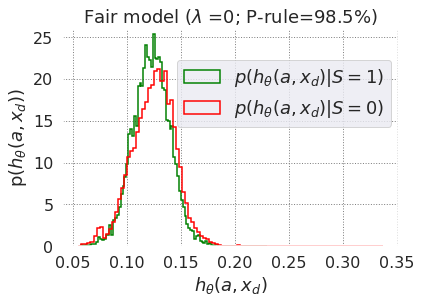

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


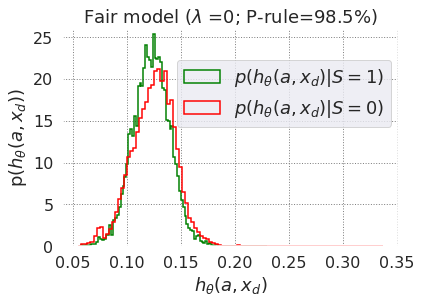

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


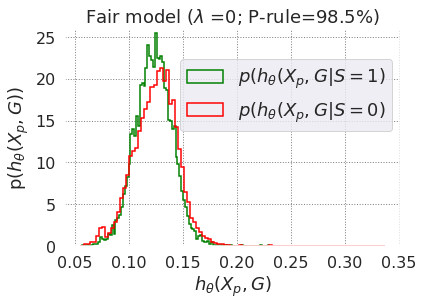

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho ], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe ], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


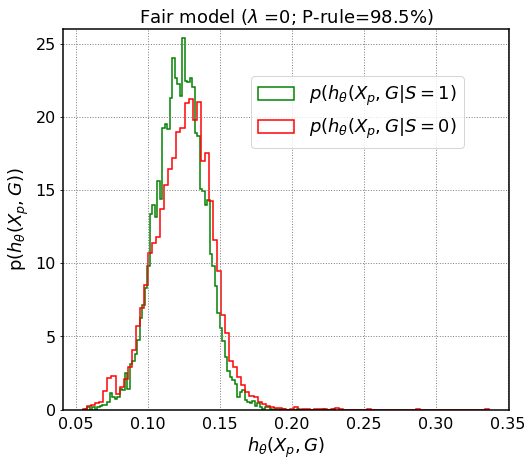

<Figure size 432x504 with 0 Axes>

In [65]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,7)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho ], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe ], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


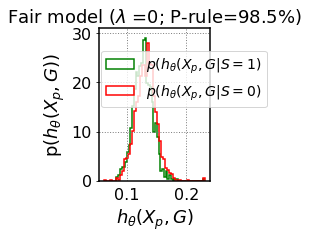

<Figure size 216x216 with 0 Axes>

In [60]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho & (y_testt.squeeze(1)>=1)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (y_testt.squeeze(1)>=1)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

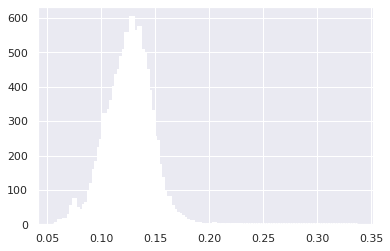

In [ ]:
_ = plt.hist(Ypredtest[Ho], bins='auto', lw=3, fc=(0, 0, 1, 0.5))
_ = plt.hist(Ypredtest[Fe], bins='auto', lw=3, fc=(1, 0, 0, 0.5))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


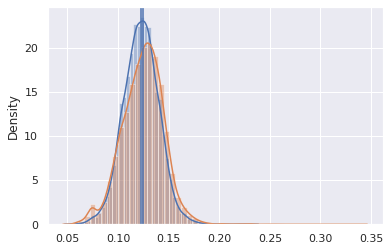

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.distplot(Ypredtest[Ho],norm_hist=1)
plt.axvline(x=Ypredtest[Ho].mean())
ax = sns.distplot(Ypredtest[Fe],norm_hist=1)
plt.axvline(x=Ypredtest[Fe].mean())

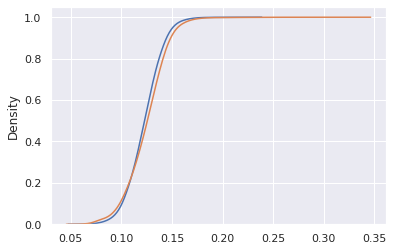

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)

ax = sns.kdeplot(Ypredtest[Ho].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe].squeeze(1),cumulative=True)


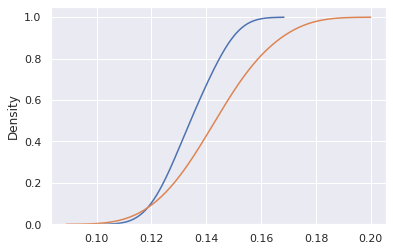

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==3)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==3)].squeeze(1),cumulative=True)


In [ ]:
(y_testt.squeeze(1)>=3).mean()

0.0006604348709611867

In [ ]:
(y_testt==0).shape

(19684, 1)

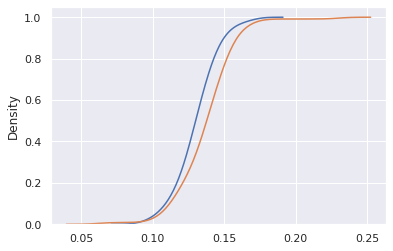

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==2)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==2)].squeeze(1),cumulative=True)


In [ ]:
(y_testt.squeeze(1)>=2).mean()

0.010770168664905507

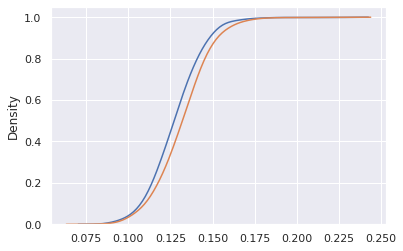

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)


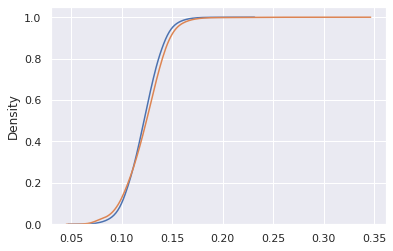

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==0)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==0)].squeeze(1),cumulative=True)

In [ ]:

ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)Ho.shape

(19684,)

In [ ]:
Ypredtest[Ho & (ytest==1)]

NameError: ignored

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, sharex=False)
g = sns.distplot(quotient, hist=True, label=protname, ax=ax1, rug=True)
ax1.set_title('basic distplot (kde=True)')
# get distplot line points
line = g.get_lines()[0]
xd = line.get_xdata()
yd = line.get_ydata()
# https://stackoverflow.com/questions/29661574/normalize-numpy-array-columns-in-python
def normalize(x):
    return (x - x.min(0)) / x.ptp(0)
#normalize points
yd2 = normalize(yd)
# plot them in another graph
ax.plot(xd, yd2)
ax.set_title('basic distplot (kde=True)\nwith normalized y plot values')

plt.show()

0.12276542506161808

PRICING NN

In [ ]:
!wget "https://raw.githubusercontent.com/vincent-grari/DIVERS/main/pricing_nn.py"

--2021-10-04 09:03:18--  https://raw.githubusercontent.com/vincent-grari/DIVERS/main/pricing_nn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4771 (4.7K) [text/plain]
Saving to: ‘pricing_nn.py.1’

pricing_nn.py.1     100%[===================>]   4.66K  --.-KB/s    in 0s      

2021-10-04 09:03:18 (63.5 MB/s) - ‘pricing_nn.py.1’ saved [4771/4771]



In [ ]:
from pricing_nn import Pricing_NN

In [ ]:
class NN_G(nn.Module):
    def __init__(self):
        super(NN_G, self).__init__()
        self.fc1 = nn.Linear(G_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_GLM(nn.Module):    
    def __init__(self):
        super(NN_GLM, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 1)
    def forward(self, x,exposure):
        h1 = torch.exp(self.fc1(x))
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

In [ ]:
P1_NN = Pricing_NN(regressor="poisson",mod_h=NN_GLM,mod_g= NN_G, batch_size = 128,nbepoch = 1024, lr = 0.0001, p_device= 'cuda')

In [ ]:
from tqdm import tqdm 
from sklearn.utils import shuffle
from torch.autograd import Variable

In [ ]:
P1_NN.fit(X_train, y_train, G_train, E_train)

KeyboardInterrupt: ignored

In [ ]:
P1_NN.predict(X_train, G_train, E_train)

tensor([[0.1014],
        [0.0891],
        [0.1915],
        ...,
        [0.0919],
        [0.0723],
        [0.1909]], device='cuda:0', grad_fn=<ExpBackward>)

In [ ]:
P1_NN.predict_g(G_train)

tensor([[13.3409],
        [16.1719],
        [11.9487],
        ...,
        [15.3951],
        [18.2578],
        [16.0916]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()


In [ ]:
print(" GINI Poi without zonier via Reg : ", gini_coefficient(y_pred2))
print(" GINI Poi without zonier via Reg : ", gini_coefficient(y_pred2t))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(y_pred2,y_traint))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE NN without zonier via Reg : ", np.mean((y_traint- y_pred2)**2))
print(" MSE NN without zonier via Reg : ", np.mean((y_testt- y_pred2t)**2))

 GINI Poi without zonier via Reg :  0.3190141080347123
 GINI Poi without zonier via Reg :  0.32111758773443716
 EDR POIS Poi without zonier via Reg :  0.08233498570906495
 EDR POIS Poi without zonier via Reg :  -0.08617379652934676
 MSE NN without zonier via Reg :  0.12984692163346045
 MSE NN without zonier via Reg :  0.13423445220097072


FAIR PRICING NN

In [29]:
table = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [114]:
from tqdm import tqdm 
from sklearn.utils import shuffle
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from tqdm import tqdm 

class Fair_Pricing_NN(torch.nn.Module): 

    def __init__(self,regressor, mod_h,mod_g,lr,batch_size,p_device,nbepoch, lambdaHGR, nbepochHGR, start_epochHGR, mod_HGR_1,mod_HGR_2): 
        super().__init__()
        self.lr = lr
        self.batch_size = int(batch_size)
        self.device = torch.device(p_device)
        self.nbepoch = int(nbepoch)
        self.model_h = mod_h()
        self.model_g = mod_g()
        self.lambdaHGR = lambdaHGR
        self.nbepochHGR = int(nbepochHGR)
        self.start_epochHGR= int(start_epochHGR)
        self.mod_HGR_1 = mod_HGR_1()
        self.mod_HGR_2 = mod_HGR_2()
        if regressor == 'poisson': 
          # Use Adam to fit the model 
          self.criterion = self.Poisson_Loss
        elif regressor == 'gamma': 
          self.criterion = self.Gamma_Loss
        else: 
          print('Le regressor est mal renseigné: ("poisson" ou "gamma")')
    def forward(self, x): 
        out = self.linear(x) 
        return out 

    def predict(self, X_train,G_train,E_train): 
        e_var = torch.FloatTensor(np.expand_dims(E_train,axis = 1)).to(self.device)
        x_var = Variable(torch.FloatTensor(X_train.values)).to(self.device)
        g_out = self.predict_g(G_train)
        yhat= self.model_h(torch.cat((x_var,g_out),1),e_var)
        return yhat

    def predict_g(self, G_train): 
        g_var = Variable((torch.FloatTensor(G_train.values))).to(self.device)
        g_out = self.model_g(g_var)
        return g_out

    def Poisson_Loss(self,yhat, y):
      #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
      loss=torch.mean(yhat-y*torch.log(yhat))
      return loss
    
    def Gamma_Loss(self,yhat, y):
      #loss = torch.mean(yhat+(y-torch.log(yhat))/torch.log(yhat))
      loss = torch.mean(-torch.log(y/yhat)+(y-yhat)/yhat)
      return loss  
    
    def EDR_POIS(self, yhat, y):
    #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
    #loss=torch.mean(yhat-y*torch.log(yhat))
      eps=0.000000000001
      res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
      return res
    
    def fit(self, X_train, y_train, G_train, E_train, S_train): 
        batch_no = len(X_train) // self.batch_size
        ##### PREDICTOR H #####
        #self.model_h=NN_POISS()
        #criterion = nn.PoissonNLLLoss()
 
        #criterion = self.Poisson_Loss
        #, eps=1e-8) #torch.nn.MSELoss() #reduction='mean'
        optimizer_h = torch.optim.Adam(self.model_h.parameters(), lr=self.lr)
        self.model_h.to(self.device)

        ##### PREDICTOR G #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_g = torch.optim.Adam(self.model_g.parameters(), lr=self.lr)
        self.model_g.to(self.device)

        ##### PREDICTOR HGR #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_HGR_1 = torch.optim.Adam(self.mod_HGR_1.parameters(), lr=self.lr)
        self.mod_HGR_1.to(self.device)
        optimizer_HGR_2 = torch.optim.Adam(self.mod_HGR_2.parameters(), lr=self.lr)
        self.mod_HGR_2.to(self.device)
        epsilon = 0.000000001
        for epoch in tqdm(range(1, self.nbepoch + 1), 'Epoch: ', leave=False):
            x_train, ytrain, g_train, e_train, s_train = shuffle(X_train.values,np.expand_dims(y_train,axis = 1),G_train.values,np.expand_dims(E_train,axis = 1),np.expand_dims(S_train,axis = 1))
            # Mini batch learning
            for i in range(batch_no):
                start = i * self.batch_size
                end = start + self.batch_size
                g_var = Variable(torch.FloatTensor(g_train[start:end])).to(self.device)
                e_var = Variable(torch.FloatTensor(e_train[start:end])).to(self.device)
                s_var = Variable(torch.FloatTensor(s_train[start:end])).to(self.device)
                x_var = Variable(torch.FloatTensor(x_train[start:end])).to(self.device)
                y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(self.device)
                # Forward + Backward + Optimize

                for l in range(1):
                  optimizer_g.zero_grad()
                  g_out = self.model_g(g_var)
                  ypred_var= self.model_h(torch.cat((x_var,g_out),1),e_var)
                  #ypred_var=  model_h(x_var,e_var)
                  #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                  #loss = torch.mean(loss)
                  loss = self.criterion(ypred_var, y_var)
                  loss.backward()
                  optimizer_g.step()
                  #print('epoch :',epoch,'loss', loss)
                ypred_var0 = ypred_var.detach()
                if epoch >=self.start_epochHGR: 
                  for k in range(self.nbepochHGR) :
                    optimizer_HGR_1.zero_grad()
                    optimizer_HGR_2.zero_grad()

                    pred_F = self.mod_HGR_1(s_var.detach().to(self.device))
                    pred_G = self.mod_HGR_2(ypred_var0.to(self.device))
                    pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                    pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))

                    ret = torch.mean(pred_F_norm * pred_G_norm)
                    loss_HGR = - ret  # maximize
                    loss_HGR.backward()

                    optimizer_HGR_1.step()
                    optimizer_HGR_2.step()


                optimizer_h.zero_grad()
                g_out = self.model_g(g_var)
                ypred_var= self.model_h(torch.cat((x_var,g_out),1),e_var)
                #ypred_var= model_h(x_var,e_var)
                #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                #loss = torch.mean(loss)
                pred_F = self.mod_HGR_1(s_var.detach().cuda())
                pred_G = self.mod_HGR_2(ypred_var)
                pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
                ret = torch.mean(pred_F_norm * pred_G_norm)
                loss = self.criterion(ypred_var, y_var) + self.lambdaHGR*ret
                loss.backward()
                optimizer_h.step()
                #print(epoch) 
                #print(ypred_var)
                if epoch >=self.start_epochHGR:   
                  print(ret)   
        yhat = self.predict(X_train, G_train, E_train).cpu().data.numpy()
        #print(yhat.shape)
        #print(y_train.shape)
        return print('DONE')

In [115]:
class NN_G(nn.Module):
    def __init__(self):
        super(NN_G, self).__init__()
        self.fc1 = nn.Linear(G_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_GLM(nn.Module):    
    def __init__(self):
        super(NN_GLM, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 1)
    def forward(self, x,exposure):
        h1 = torch.exp(self.fc1(x))
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1


In [116]:
lamb_HGR =1
P1_NN = Fair_Pricing_NN(regressor="poisson",mod_h=NN_GLM,mod_g= NN_G, batch_size = 1024,nbepoch = 1024, lr = 0.0001, p_device= 'cuda', lambdaHGR=lamb_HGR, nbepochHGR=10, start_epochHGR=1025, mod_HGR_1=Net_HGR,mod_HGR_2= Net2_HGR)

In [117]:
P1_NN.fit(X_train, y_train, G_train, E_train, S1_train)

DONE


In [34]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [35]:
def DispFNR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==1) & (z_values==0)].mean()-ypred_z_1[(y==1) & (z_values==1)].mean())
    return result
def DispFPR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==0) & (z_values==0)].mean()-ypred_z_1[(y==0) & (z_values==1)].mean())
    return result


In [36]:
!wget "http://grarivincent.com/research/rdc.py"
from rdc import rdc

--2021-10-14 12:30:27--  http://grarivincent.com/research/rdc.py
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2782 (2.7K) [text/html]
Saving to: ‘rdc.py.2’

rdc.py.2            100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-10-14 12:30:28 (356 MB/s) - ‘rdc.py.2’ saved [2782/2782]



In [37]:

class HGR_NN(nn.Module):

    def __init__(self, model_F, model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var, nb):
        for j in range(nb):
            pred_F = self.mF(yhat.detach())
            pred_G = self.mG(y2_var.detach())

            epsilon = 0.0001
            pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
            pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
            pred_F_norm[torch.isnan(pred_F_norm)] = 0
            pred_G_norm[torch.isnan(pred_G_norm)] = 0

            ret = torch.mean(pred_F_norm * pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            # print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



In [38]:
def DispER(y_pred, y, z_values, threshold=0.5):
    RES=(y_pred-y)
    RES_1 = RES[z_values == 1]
    RES_0 = RES[z_values == 0]
    odds = np.abs(RES_1.mean() / RES_0.mean())
    return np.min([odds, 1/odds]) * 100

In [39]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
print(" Prule train : ", p_rule(y_pred2,S1_train))
print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
                          p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
                          DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTrain2,
                          HGRNNTest2
                          ]])

NameError: ignored

0.98313093


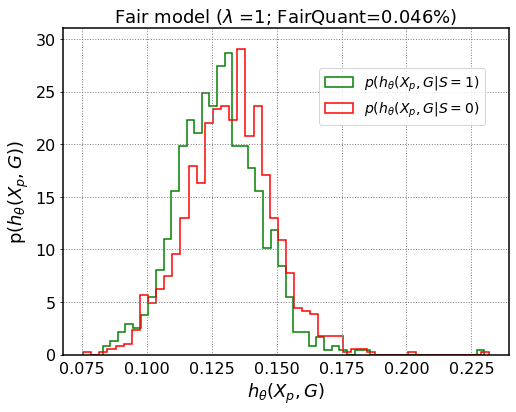

<Figure size 576x432 with 0 Axes>

In [90]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho & (y_testt.squeeze(1))], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (y_testt.squeeze(1))], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP_Test_distrib25_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) + '.pdf')
fig.savefig("DP_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.98313093


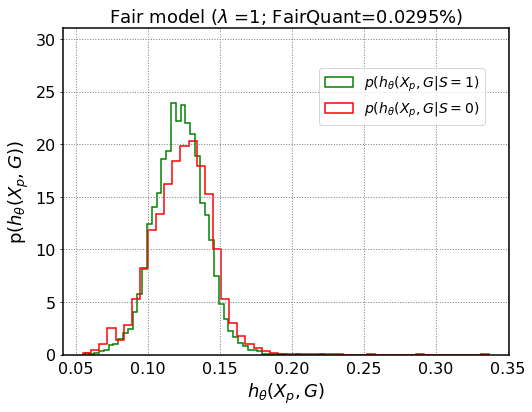

<Figure size 576x432 with 0 Axes>

In [91]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)==0)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,4)) +'%)', fontsize=18)
fig.savefig("DP0_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,4)) + '.pdf')
plt.show()
plt.clf()

0.98313093


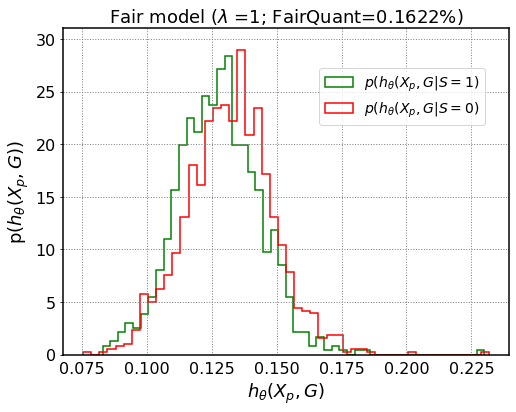

<Figure size 576x432 with 0 Axes>

In [92]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)==1)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,4)) +'%)', fontsize=18)
fig.savefig("DP1_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,4)) + '.pdf')
plt.show()
plt.clf()

0.98313093


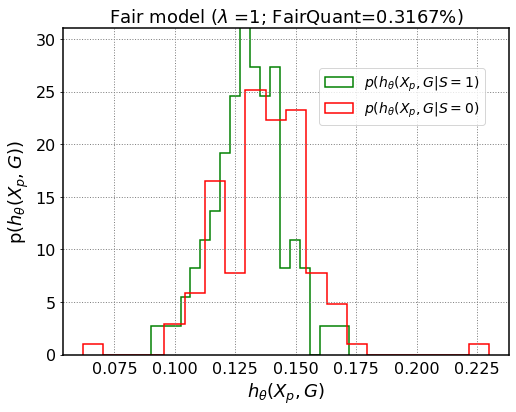

<Figure size 576x432 with 0 Axes>

In [93]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)>=2)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=20, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=20, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,4)) +'%)', fontsize=18)
fig.savefig("DP2_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,4)) + '.pdf')
plt.show()
plt.clf()

In [78]:
print(y_pred2[Filtre].squeeze(1).shape)
print(y_traint[Filtre].squeeze(1).shape)
print(S1_train[Filtre].shape)

IndexError: ignored

In [81]:
Filtre.shape

(19684,)

In [79]:
y_pred2.shape

(78733, 1)

0.98313093


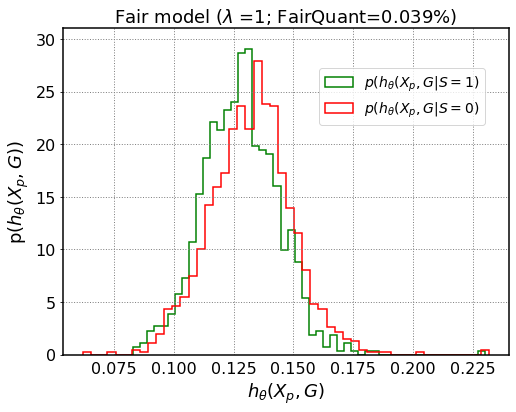

<Figure size 576x432 with 0 Axes>

In [74]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho & (y_testt.squeeze(1)>=1)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (y_testt.squeeze(1)>=1)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP_Test_distrib25_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0]*100,3)) + '.pdf')
fig.savefig("DP_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

In [111]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
g_pred2= P1_NN.predict_g(G_train).cpu().data.numpy()
g_pred2t= P1_NN.predict_g(G_test).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
G_HGRNNTrain2=HGR_NNP(torch.FloatTensor(g_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
G_HGRNNTest2=HGR_NNP(torch.FloatTensor(g_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" G HGR S2 train : ", G_HGRNNTrain2)
print(" G HGR S2 test : ",  G_HGRNNTest2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0],
                          FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0],
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          G_HGRNNTrain2,
                          G_HGRNNTest2,
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ]])
np.savetxt('table.out', table) 

 GINI Train :  0.32766944229283845
 GINI Test :  0.32975697079820165
 EDR Train :  0.08835582450161972
 EDR Test :  -0.12279924423220279
 MSE Train :  0.12941552633531944
 MSE Test :  0.13423799231587527
 DispER train :  62.84232262973399
 DispER test :  67.84531281935448
 FairQuant train :  (0.0003931894898414612, 2.576632915363142e-07)
 FairQuant test :  (0.0004587247967720032, 3.507140652891927e-07)
 RDC S1 train :  0.07373399213097653
 RDC S1 test :  0.07241482362788057
 RDC S2 train :  0.05994389604469667
 RDC S2 test :  0.07525679585497563
 HGR S1 train :  0.085389465
 HGR S1 test :  0.08513364
 HGR S2 train :  0.0
 HGR S2 test :  0.0
 G HGR S2 train :  0.007984397
 G HGR S2 test :  0.005902006


In [ ]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [109]:
table

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0.32766944229283845, 0.32975697079820165, 0.08835582450161972,
        -0.12279924423220279, 0.12941552633531944, 0.13423799231587527,
        (0.0003931894898414612, 2.576632915363142e-07),
        (0.0004587247967720032, 3.507140652891927e-07),
        0.0737482527641285, 0.07245224579319033, 0.05995347620919218,
        0.0752604165250205, array(0.00826486, dtype=float32),
        array(0.00600263, dtype=float32),
        array(0.08493204, dtype=float32),
        array(0.08092179, dtype=float32), array(0., dtype=float32)]],
      dtype=object)

In [105]:
len([lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train),
                          FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          G_HGRNNTrain2,
                          G_HGRNNTest2,
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ])


18

In [106]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 G HGR S2 train :  0.0079840105
 G HGR S2 test :  0.0079840105
